<a href="https://colab.research.google.com/github/fzanart/GHDomains/blob/main/Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
%%capture
!pip install -U sentence-transformers
!pip install flaml

In [48]:
from sentence_transformers import SentenceTransformer
from flaml import AutoML
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.metrics import classification_report, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import markdown
import lxml
from bs4 import BeautifulSoup
import re
import time
import pickle
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [49]:
#Imports:

# Clasification model
with open('/content/drive/MyDrive/GHDomains/Resources/automl.pkl', 'rb') as fp:
  automl = pickle.load(fp)
# Label encoder
with open('/content/drive/MyDrive/GHDomains/Resources/label_encoder.pkl', 'rb') as fp:
  le = pickle.load(fp)
# Num scaler
with open('/content/drive/MyDrive/GHDomains/Resources/num_scaler.pkl', 'rb') as fp:
  scaler = pickle.load(fp)
# Column names
with open('/content/drive/MyDrive/GHDomains/Resources/column_names.pkl', 'rb') as fp:
  column_names = pickle.load(fp)

In [50]:
new_popular_df = pd.read_csv('/content/drive/MyDrive/GHDomains/New_popular_download/all_repos.csv')
new_popular_df = new_popular_df.rename(columns={"README": "Readme"}) 
new_popular_df

,Name,Description,Readme,Labels,Contributors,Languages,Topics,Contents,Licence,Stars,Forks,Releases,Workflows
0,vuejs/devtools,⚙️ Browser devtools extension for debugging Vu...,# vue-devtools\n\n![screenshot](./media/screen...,"['accepted proposition', 'bug', 'cannot reprod...","['Akryum', 'yyx990803', 'posva', 'bartlomieju'...","['TypeScript', 'Vue', 'JavaScript', 'HTML', 'S...",NaN,"['.browserslistrc', '.circleci', '.eslintrc.js...",MIT License,22091,3684,73,['Create Release']
1,futurice/android-best-practices,"Do's and Don'ts for Android development, by Fu...",# Best practices in Android development\n\nAvo...,"['2018', 'answered', 'bug', 'discussion', 'dup...","['staltz', 'peter-tackage', 'minsoopark', 'and...",NaN,"['best-practices', 'android-development', 'and...","['LICENSE', 'README.md', 'translations']",Other,19943,3305,0,NaN
2,microsoft/Web-Dev-For-Beginners,"24 Lessons, 12 Weeks, Get Started as a Web Dev...",[![GitHub license](https://img.shields.io/gith...,"['bug', 'dependencies', 'documentation', 'dupl...","['jlooper', 'ManuSquall', 'San1ay', 'silversky...","['JavaScript', 'HTML', 'CSS', 'Vue']","['javascript', 'curriculum', 'html', 'css', 'e...","['.github', '.gitignore', '.nojekyll', '1-gett...",MIT License,44328,6279,0,"['Azure Static Web Apps CI/CD', 'Lock closed i..."
3,airbnb/react-sketchapp,render React components to Sketch ⚛️💎,"<div align=""center"">\n <img alt=""react-sketch...","['awaiting-review', 'bug', 'chore', 'discuss',...","['jongold', 'mathieudutour', 'macintoshhelper'...","['TypeScript', 'JavaScript']","['react-sketchapp', 'react', 'sketch', 'sketch...","['.bookignore', '.editorconfig', '.github', '....",MIT License,14874,864,28,NaN
4,eugeneyan/applied-ml,📚 Papers & tech blogs by companies sharing the...,"# applied-ml\nCurated papers, articles, and bl...","['bug', 'documentation', 'duplicate', 'enhance...","['eugeneyan', 'shreyansh26', 'chmnsk', 'nilesh...",NaN,"['applied-machine-learning', 'production', 'ap...","['CONTRIBUTING.md', 'LICENSE', 'README.md']",MIT License,19001,2615,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,railsware/upterm,A terminal emulator for the 21st century.,[![Join the chat at https://gitter.im/railswar...,"['ANSI', 'Autocompletion', 'Blocked', 'Bug: Co...","['vlad-shatskyi', 'drew-gross', 'ShockOne', 'g...","['TypeScript', 'HTML', 'Dockerfile']","['tty', 'terminal', 'terminal-emulators', 'con...","['.dockerignore', '.gitignore', '.node-version...",MIT License,19415,657,187,NaN
437,matryer/xbar,Put the output from any script or program into...,[![](xbarapp.com/public/img/xbar-menu-preview....,"['! invalid', '? question', '→? future maybe',...","['matryer', 'iosdeveloper', 'leaanthony', 'muh...","['Go', 'Objective-C', 'HTML', 'Svelte', 'JavaS...","['mac', 'macosx', 'bitbar', 'menubar', 'script...","['.github', '.gitignore', '.vscode', 'LICENSE....",MIT License,15908,615,69,NaN
438,thedaviddias/Front-End-Checklist,🗂 The perfect Front-End Checklist for modern w...,"<h1 align=""center"">\n<br>\n <img src=""https:/...","['#Status: Add into the app', '#Status: Awaiti...","['thedaviddias', 'greenkeeper[bot]', 'jochenki...",NaN,"['frontend', 'front-end-development', 'front-e...","['.editorconfig', '.github', '.gitignore', 'CH...",Creative Commons Zero v1.0 Universal,58604,4783,1,['pages-build-deployment']
439,electronicarts/CnC_Remastered_Collection,NaN,# CnC_Remastered_Collection,"['bug', 'documentation', 'duplicate', 'enhance...","['PG-SteveT', 'bmattea', 'rparolin']","['C++', 'C#', 'C', 'Assembly', 'Python', 'Obje...",NaN,"['CnCRemastered.sln', 'CnCTDRAMapEditor.sln', ...",Other,15990,4274,0,NaN


In [51]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [52]:
def join_words_from_lists(text, join=False):
  text = str(text)
  if text == 'nan':
    return ''
  else:
    text = text[1:-1]
    text = text.replace('\'','')
    text = text.split(',')
    if join:
      text = ' '.join([word.strip() for word in text])
    return text

def clean_htmltags(text):
    html = markdown.markdown(text)                                # convert the code to html
    soup = BeautifulSoup(html, "lxml")                            # html.parser #XML stands for "eXtensible Markup Language",
    
    [s.extract() for s in soup(['iframe', 'script'])]             # eliminate html tags 
    stripped_text = soup.get_text()                               # get the rest of the text
    stripped_text = re.sub(r'[\r|\n|\r\n]+', ' ', stripped_text)  # delete remaining tags
    text = stripped_text                                          # voila!
                                    
    return text

def vectorize_categorical(df_Serie, prefix):
    lp_index = df_Serie.index

    vect = CountVectorizer(tokenizer=join_words_from_lists)
    lp_Serie = vect.fit_transform(df_Serie.astype(str))

    lp_Serie = pd.DataFrame(lp_Serie.toarray(), columns=vect.get_feature_names_out(), index=lp_index).add_prefix(prefix)
    lp_Serie = lp_Serie.astype(pd.SparseDtype(np.int64))
    return lp_Serie

In [53]:
def fit_transform(df, selected_features):

  # Apply text pre-processing
  df['Labels'] = df['Labels'].apply(lambda x: join_words_from_lists(x, join=True))
  df['Readme'] = df['Readme'].astype(str)
  df['Readme'] = pd.Series([clean_htmltags(x) for x in df['Readme']]) #df['Readme'].apply(lambda x: clean_htmltags(x)) #
  df['Readme'] = df['Readme'].apply(lambda x: re.sub('\s{2,}', " ", x))
  df['Description'] = df['Description'].astype(str)
  df['Description'] = df['Description'].replace('nan','')
  df['Text_data']   = df['Description'] + df['Readme'] + df['Labels']
  transformed_df = model.encode(df['Text_data'].to_list())

  # Vectorise categorical features
  cn_vect = vectorize_categorical(df['Contributors'], 'cn: ')
  pl_vect = vectorize_categorical(df['Languages'], 'pl: ')
  tp_vect = vectorize_categorical(df['Topics'], 'tp: ')
  ct_vect = vectorize_categorical(df['Contents'], 'ct: ')
  li_vect = vectorize_categorical(df['Licence'], 'li: ')

  # transform numbers of stars, forks y releases
  num_vectors = df[['Stars','Forks', 'Releases']].astype(np.float64)
  num_columns = num_vectors.columns
  num_index = num_vectors.index
  num_vectors = scaler.transform(num_vectors)
  num_vectors = pd.DataFrame(num_vectors, columns=num_columns, index=num_index)

  # Concat the dataframe and filter the columns to plug into the model
  transformed_df = pd.DataFrame(transformed_df, index=df.index).add_prefix('Text ')
  transformed_df = pd.concat([transformed_df, cn_vect, pl_vect, tp_vect, ct_vect, li_vect, num_vectors], axis=1)
  transformed_df = transformed_df.reindex(columns=column_names, fill_value=0)

  return transformed_df

In [54]:
transformed_df = fit_transform(df=new_popular_df, selected_features=column_names)
prediction = automl.predict(transformed_df.to_numpy())

In [ ]:
le.inverse_transform(prediction)

In [58]:
new_popular_df['Predicted_labels'] = le.inverse_transform(prediction)
new_popular_df

In [60]:
new_popular_df.to_csv('/content/drive/MyDrive/GHDomains/Resources/new_popular_df_predicted.csv', index=False)

In [61]:
less_popular_df = pd.read_csv('/content/drive/MyDrive/GHDomains/Less_popular_download/all_repos.csv')
less_popular_df = less_popular_df.rename(columns={"README": "Readme"}) 
less_popular_df

,Name,Description,Readme,Labels,Contributors,Languages,Topics,Contents,Licence,Stars,Forks,Releases,Workflows
0,yetanother-blog/indiepen,An independent and privacy-friendly solution t...,# Indiepen 📝\n\n[![Netlify Status](https://api...,"['bug', 'depfu', 'documentation', 'duplicate',...","['HenrikFricke', 'depfu[bot]', 'andrew-secret'...","['HTML', 'JavaScript', 'CSS', 'TypeScript']","['cookieless', 'accessible', 'performant', 'in...","['.editorconfig', '.gitignore', '.netlify', '....",MIT License,254,7,0,NaN
1,SnowdogApps/magento2-menu,Provides powerful menu editor to replace categ...,[![Packagist](https://img.shields.io/packagist...,"['awaiting release', 'bug', 'dependencies', 'd...","['akai-z', 'Igloczek', 'talalus', 'dawiddczaja...","['JavaScript', 'PHP', 'Vue', 'Less', 'HTML']","['hacktoberfest', 'extenstions', 'menus', 'mag...","['.eslintignore', '.eslintrc.js', '.github', '...",MIT License,222,82,11,"['Frontend', 'Backend Coding Standard', 'Backe..."
2,api-platform/demo,Demo app for the API Platform framework,"<h1 align=""center""><a href=""https://api-platfo...","['bug', 'dependencies', 'duplicate', 'easy pic...","['vincentchalamon', 'dunglas', 'pborreli', 'al...","['TypeScript', 'PHP', 'Shell', 'Dockerfile', '...","['api-platform', 'api', 'symfony', 'demo', 're...","['.editorconfig', '.gitattributes', '.github',...",MIT License,219,148,0,"['Cleanup', 'CI', 'CD', 'Clean']"
3,rroemhild/docker-test-openldap,Docker OpenLDAP Server for testing LDAP applic...,# OpenLDAP Docker Image for testing\n\n![Docke...,"['bug', 'duplicate', 'enhancement', 'help want...","['rroemhild', 'AnalogJ', 'rbarbey', 'Chocobozz...",['Dockerfile'],"['docker', 'openldap', 'ldap', 'futurama', 'sl...","['.dockerignore', '.github', '.gitignore', 'CH...",MIT License,220,96,1,['Docker']
4,ikostrikov/jaxrl,JAX (Flax) implementation of algorithms for De...,[![DOI](https://zenodo.org/badge/330059679.svg...,"['bug', 'documentation', 'duplicate', 'enhance...","['ikostrikov', 'erwincoumans']","['Jupyter Notebook', 'Python', 'Dockerfile', '...","['deep-learning', 'deep-reinforcement-learning...","['.gitignore', 'LICENSE', 'README.md', 'beauti...",MIT License,278,23,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,noib3/dotfiles,:house: Procrastinating has never felt this pr...,# :european_castle: dotfiles\n\nThis repositor...,"['bug', 'documentation', 'duplicate', 'enhance...",['noib3'],"['Nix', 'Lua', 'Python', 'CSS', 'Shell', 'Vim ...","['dotfiles', 'nixos', 'home-manager', 'neovim-...","['.github', 'README.md', 'configs', 'configura...",NaN,46,4,0,NaN
95,ntucker/anansi,React web applications for perfectionists with...,"# 🕷 Anansi\n\n> Production ready, developer fr...","['bug', 'dependencies', 'duplicate', 'enhancem...","['ntucker', 'dependabot[bot]', 'renovate[bot]'...","['JavaScript', 'TypeScript', 'Smarty', 'SCSS',...","['react', 'webpack', 'babel', 'webframework']","['.circleci', '.commitlintrc.js', '.editorconf...","BSD 3-Clause ""New"" or ""Revised"" License",31,4,1186,"['Compressed Size', 'Combine PRs', 'Lint Commi..."
96,googleapis/java-bigtable,NaN,# Google Cloud Bigtable Client for Java\n\nJav...,"[':rotating_light:', 'api: bigtable', 'automer...","['renovate-bot', 'yoshi-automation', 'igorbern...","['Java', 'Shell', 'Python', 'Batchfile']",NaN,"['.github', '.gitignore', '.kokoro', '.readme-...",Apache License 2.0,38,53,65,"['auto-merge-readme', 'auto-release', 'ci', 's..."
97,hotio/sonarr,NaN,# Documentation\n\nAll our documentation is lo...,"['bug', 'dependencies', 'duplicate', 'enhancem...","['mrhotio', 'dependabot[bot]', 'actions-user',...",NaN,['docker-image'],"['LICENSE', 'README.md', 'tags.json']",GNU General Public License v3.0,46,2,0,['build']


In [ ]:
transformed_df = fit_transform(df=less_popular_df, selected_features=column_names)
prediction = automl.predict(transformed_df.to_numpy())
le.inverse_transform(prediction)

In [63]:
less_popular_df['Predicted_labels'] = le.inverse_transform(prediction)
less_popular_df

,Name,Description,Readme,Labels,Contributors,Languages,Topics,Contents,Licence,Stars,Forks,Releases,Workflows,Text_data,Predicted_labels
0,yetanother-blog/indiepen,An independent and privacy-friendly solution t...,Indiepen 📝 An independent and privacy-friendly...,bug depfu documentation duplicate embed enhanc...,"['HenrikFricke', 'depfu[bot]', 'andrew-secret'...","['HTML', 'JavaScript', 'CSS', 'TypeScript']","['cookieless', 'accessible', 'performant', 'in...","['.editorconfig', '.gitignore', '.netlify', '....",MIT License,254,7,0,NaN,An independent and privacy-friendly solution t...,Web libraries and frameworks
1,SnowdogApps/magento2-menu,Provides powerful menu editor to replace categ...,Magento 2 Menu Provides powerful menu editor ...,awaiting release bug dependencies duplicate en...,"['akai-z', 'Igloczek', 'talalus', 'dawiddczaja...","['JavaScript', 'PHP', 'Vue', 'Less', 'HTML']","['hacktoberfest', 'extenstions', 'menus', 'mag...","['.eslintignore', '.eslintrc.js', '.github', '...",MIT License,222,82,11,"['Frontend', 'Backend Coding Standard', 'Backe...",Provides powerful menu editor to replace categ...,Web libraries and frameworks
2,api-platform/demo,Demo app for the API Platform framework,This application is a demonstration for the A...,bug dependencies duplicate easy pick enhanceme...,"['vincentchalamon', 'dunglas', 'pborreli', 'al...","['TypeScript', 'PHP', 'Shell', 'Dockerfile', '...","['api-platform', 'api', 'symfony', 'demo', 're...","['.editorconfig', '.gitattributes', '.github',...",MIT License,219,148,0,"['Cleanup', 'CI', 'CD', 'Clean']",Demo app for the API Platform framework This a...,Web libraries and frameworks
3,rroemhild/docker-test-openldap,Docker OpenLDAP Server for testing LDAP applic...,OpenLDAP Docker Image for testing This image p...,bug duplicate enhancement help wanted invalid ...,"['rroemhild', 'AnalogJ', 'rbarbey', 'Chocobozz...",['Dockerfile'],"['docker', 'openldap', 'ldap', 'futurama', 'sl...","['.dockerignore', '.github', '.gitignore', 'CH...",MIT License,220,96,1,['Docker'],Docker OpenLDAP Server for testing LDAP applic...,Software tools
4,ikostrikov/jaxrl,JAX (Flax) implementation of algorithms for De...,JAX (Flax) RL This repository contains JAX (F...,bug documentation duplicate enhancement good f...,"['ikostrikov', 'erwincoumans']","['Jupyter Notebook', 'Python', 'Dockerfile', '...","['deep-learning', 'deep-reinforcement-learning...","['.gitignore', 'LICENSE', 'README.md', 'beauti...",MIT License,278,23,1,NaN,JAX (Flax) implementation of algorithms for De...,Non-web libraries and frameworks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,noib3/dotfiles,:house: Procrastinating has never felt this pr...,:european_castle: dotfiles This repository con...,bug documentation duplicate enhancement good f...,['noib3'],"['Nix', 'Lua', 'Python', 'CSS', 'Shell', 'Vim ...","['dotfiles', 'nixos', 'home-manager', 'neovim-...","['.github', 'README.md', 'configs', 'configura...",NaN,46,4,0,NaN,:house: Procrastinating has never felt this pr...,Software tools
95,ntucker/anansi,React web applications for perfectionists with...,"🕷 Anansi Production ready, developer friendly....",bug dependencies duplicate enhancement feature...,"['ntucker', 'dependabot[bot]', 'renovate[bot]'...","['JavaScript', 'TypeScript', 'Smarty', 'SCSS',...","['react', 'webpack', 'babel', 'webframework']","['.circleci', '.commitlintrc.js', '.editorconf...","BSD 3-Clause ""New"" or ""Revised"" License",31,4,1186,"['Compressed Size', 'Combine PRs', 'Lint Commi...",React web applications for perfectionists with...,Web libraries and frameworks
96,googleapis/java-bigtable,,Google Cloud Bigtable Client for Java Java idi...,:rotating_light: api: bigtable automerge autom...,"['renovate-bot', 'yoshi-automation', 'igorbern...","['Java', 'Shell', 'Python', 'Batchfile']",NaN,"['.github', '.gitignore', '.kokoro', '.readme-...",Apache License 2.0,38,53,65,"['auto-merge-readme', 'auto-release', 'ci', 's...",Google Cloud Bigtable Client f

In [71]:
ct_labels = pd.read_csv('/content/drive/MyDrive/GHDomains/ct_labels.csv', skiprows=2)
join_data = pd.merge(ct_labels, less_popular_df[['Name','Predicted_labels']], on ='Name', how ='inner')

In [72]:
join_data

,Name,Christoph's Domain,Predicted_labels
0,yetanother-blog/indiepen,Web libraries and frameworks,Web libraries and frameworks
1,SnowdogApps/magento2-menu,Web libraries and frameworks,Web libraries and frameworks
2,api-platform/demo,Non-web libraries and frameworks,Web libraries and frameworks
3,open-telemetry/opentelemetry-ruby,Non-web libraries and frameworks,Non-web libraries and frameworks
4,rroemhild/docker-test-openldap,Application & System software,Software tools
5,ikostrikov/jaxrl,Non-web libraries and frameworks,Non-web libraries and frameworks
6,balena-io-library/base-images,Application & System software,Documentation
7,BitBagCommerce/SyliusCmsPlugin,Application & System software,Application & System software
8,GPUOpen-LibrariesAndSDKs/RadeonProRenderBlende...,Software tools,Non-web libraries and frameworks
9,ObsidianLabs/EthereumStudio,Software tools,Software tools


In [73]:
print(classification_report(join_data['Christoph\'s Domain'], join_data['Predicted_labels'], target_names=le.classes_))

                                  precision    recall  f1-score   support

   Application & System software       0.40      0.17      0.24        12
                   Documentation       0.25      0.50      0.33         2
Non-web libraries and frameworks       0.56      0.75      0.64        12
                  Software tools       0.69      0.69      0.69        13
    Web libraries and frameworks       0.67      0.73      0.70        11

                        accuracy                           0.58        50
                       macro avg       0.51      0.57      0.52        50
                    weighted avg       0.57      0.58      0.56        50



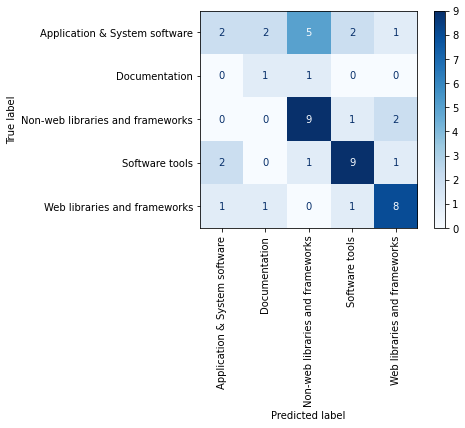

In [74]:
cnf_matrix = confusion_matrix(join_data['Christoph\'s Domain'], join_data['Predicted_labels'])
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=le.classes_).plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

In [75]:
less_popular_df.to_csv('/content/drive/MyDrive/GHDomains/Resources/less_popular_df_predicted.csv', index=False)